In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression

# Load your dataset into a DataFrame
data = pd.read_csv('../Data/CSV/train.csv')

# Group the data by 'site_id'
groups = data.groupby('site_id')

# Define a function to impute missing values using linear regression within each group
def impute_missing_with_regression_within_group(group):
    # Create a copy of the group to avoid modifying the original DataFrame
    group_copy = group.copy()

    # Check if there are missing values in the group
    if group_copy['volume'].isna().any():
        # Split the data into observed and missing values
        observed = group_copy.dropna()
        missing = group_copy[group_copy['volume'].isna()]

        # Check if there are enough observed values to perform regression
        if len(observed) > 1:
            # Create a linear regression model
            model = LinearRegression()
            X = observed[['year']]
            y = observed['volume']

            # Fit the model
            model.fit(X, y)

            # Predict the missing values
            missing['volume'] = model.predict(missing[['year']])

        # Update the group_copy with the imputed values
        group_copy.update(missing)

    return group_copy

# Apply the impute_missing_with_regression_within_group function to each group
imputed_data = groups.apply(impute_missing_with_regression_within_group)

# Concatenate the imputed groups back into a single DataFrame
imputed_data = imputed_data.reset_index(drop=True)

# Your imputed data now contains estimates for the missing values within each group


In [2]:
imputed_data[imputed_data['site_id']=='hungry_horse_reservoir_inflow']

,site_id,year,volume
757,hungry_horse_reservoir_inflow,1911,2178.526000
758,hungry_horse_reservoir_inflow,1912,1973.732000
759,hungry_horse_reservoir_inflow,1913,3220.839000
760,hungry_horse_reservoir_inflow,1914,2018.288241
761,hungry_horse_reservoir_inflow,1915,2018.681838
...,...,...,...
855,hungry_horse_reservoir_inflow,2014,2596.926000
856,hungry_horse_reservoir_inflow,2016,1627.341000
857,hungry_horse_reservoir_inflow,2018,2831.197000
858,hungry_horse_reservoir_inflow,2020,2268.463000


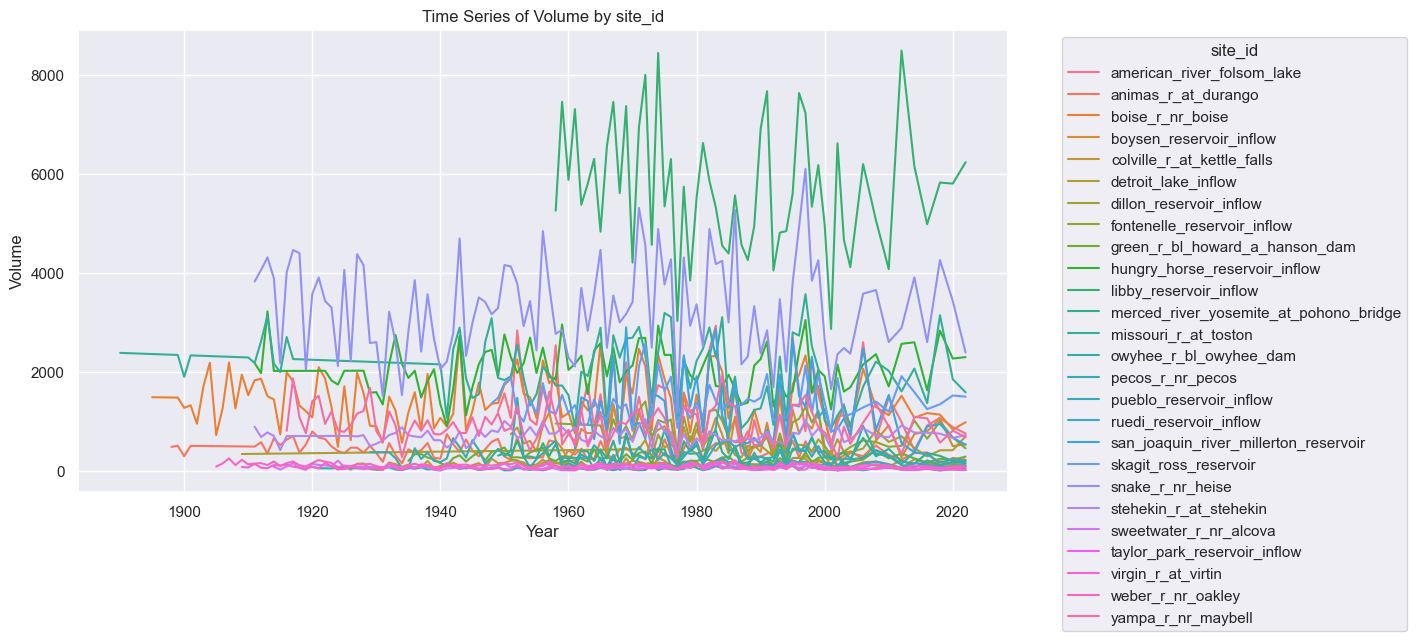

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have your data with 'site_id', 'year', and 'volume' columns
# Replace 'your_data' with your actual DataFrame
sns.set(style="darkgrid")
plt.figure(figsize=(12, 6))

# Create a line plot with 'site_id' as the hue
sns.lineplot(x="year", y="volume", hue="site_id", data=imputed_data)

# Add labels and a legend
plt.title("Time Series of Volume by site_id")
plt.xlabel("Year")
plt.ylabel("Volume")
plt.legend(title='site_id', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()


In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

# Load your dataset into a DataFrame (replace with your data loading process)
data = imputed_data

# Ensure the data is sorted by 'year'
data = data.sort_values(by='year')

# Encode 'site_id' if needed

# Split the data into training and testing sets
train_data, test_data = train_test_split(data, test_size=0.2, shuffle=False)  # Split based on time

# Define a function to create sequences from the data
def create_sequences(data, sequence_length):
    sequences = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i+sequence_length])
    return np.array(sequences)

# Create sequences of data
sequence_length = 10  # Adjust the sequence length as needed
train_sequences = create_sequences(train_data['volume'].values, sequence_length)
test_sequences = create_sequences(test_data['volume'].values, sequence_length)

# Create the LSTM model
model = keras.Sequential()
model.add(keras.layers.LSTM(50, activation='relu', input_shape=(sequence_length, 1)))
model.add(keras.layers.Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(train_sequences, train_sequences[:, -1], epochs=50, batch_size=32)

# Evaluate the model
test_loss = model.evaluate(test_sequences, test_sequences[:, -1])
print(f'Test Loss: {test_loss}')

# Make predictions
predictions = model.predict(test_sequences)

# You can use predictions for forecasting future 'volume' values.

Epoch 1/50
55/55 [==============================] - 1s 3ms/step - loss: 2516719.0000
Epoch 2/50
55/55 [==============================] - 0s 2ms/step - loss: 1561669.7500
Epoch 3/50
55/55 [==============================] - 0s 2ms/step - loss: 877638.1875
Epoch 4/50
55/55 [==============================] - 0s 2ms/step - loss: 567255.5000
Epoch 5/50
55/55 [==============================] - 0s 2ms/step - loss: 395579.5625
Epoch 6/50
55/55 [==============================] - 0s 2ms/step - loss: 282183.5312
Epoch 7/50
55/55 [==============================] - 0s 2ms/step - loss: 292094.7188
Epoch 8/50
55/55 [==============================] - 0s 2ms/step - loss: 475592.0625
Epoch 9/50
55/55 [==============================] - 0s 2ms/step - loss: 364328.7188
Epoch 10/50
55/55 [==============================] - 0s 3ms/step - loss: 261729.3750
Epoch 11/50
55/55 [==============================] - 0s 2ms/step - loss: 256932.9375
Epoch 12/50
55/55 [==============================] - 0s 2ms/step - loss:

In [8]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Load your dataset into a DataFrame (replace with your data loading process)
data = imputed_data

# Ensure the data is sorted by 'year'
data = data.sort_values(by='year')

# Encode 'site_id' if needed

# Split the data into training and testing sets
train_data, test_data = train_test_split(data, test_size=0.2, shuffle=False)  # Split based on time

# Define a function to create sequences from the data
def create_sequences(data, sequence_length):
    sequences = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i+sequence_length])
    return np.array(sequences)

# Create sequences of data
sequence_length = 10  # Adjust the sequence length as needed

# Create a MinMaxScaler instance
scaler = MinMaxScaler()

# Normalize the training data
train_sequences_normalized = scaler.fit_transform(train_sequences)
test_sequences_normalized = scaler.transform(test_sequences)

# Create the LSTM model
model = keras.Sequential()
model.add(keras.layers.LSTM(50, activation='relu', input_shape=(sequence_length, 1)))
model.add(keras.layers.Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(train_sequences_normalized, train_sequences_normalized[:, -1], epochs=50, batch_size=32)

# Evaluate the model
test_loss = model.evaluate(test_sequences_normalized, test_sequences_normalized[:, -1])
print(f'Test Loss (Normalized): {test_loss}')

# Make predictions on the normalized data
predictions_normalized = model.predict(test_sequences_normalized)

# Inverse transform predictions to the original scale
# predictions_original_scale = scaler.inverse_transform(predictions_normalized)

# You can use predictions_original_scale for forecasting future 'volume' values.

Epoch 1/50
55/55 [==============================] - 1s 2ms/step - loss: 0.0191
Epoch 2/50
55/55 [==============================] - 0s 2ms/step - loss: 0.0157
Epoch 3/50
55/55 [==============================] - 0s 2ms/step - loss: 0.0136
Epoch 4/50
55/55 [==============================] - 0s 2ms/step - loss: 0.0104
Epoch 5/50
55/55 [==============================] - 0s 2ms/step - loss: 0.0037
Epoch 6/50
55/55 [==============================] - 0s 2ms/step - loss: 3.0924e-04
Epoch 7/50
55/55 [==============================] - 0s 2ms/step - loss: 1.4603e-04
Epoch 8/50
55/55 [==============================] - 0s 2ms/step - loss: 1.1525e-04
Epoch 9/50
55/55 [==============================] - 0s 2ms/step - loss: 9.7465e-05
Epoch 10/50
55/55 [==============================] - 0s 2ms/step - loss: 7.3280e-05
Epoch 11/50
55/55 [==============================] - 0s 2ms/step - loss: 6.1754e-05
Epoch 12/50
55/55 [==============================] - 0s 2ms/step - loss: 4.2071e-05
Epoch 13/50
55/55 [==

In [9]:
from sklearn.metrics import mean_squared_error

# Calculate RMSE for normalized predictions and actual values
rmse_normalized = np.sqrt(mean_squared_error(test_sequences_normalized[:, -1], predictions_normalized))
print(f'RMSE (Normalized): {rmse_normalized}')

RMSE (Normalized): 0.0037368331853351766


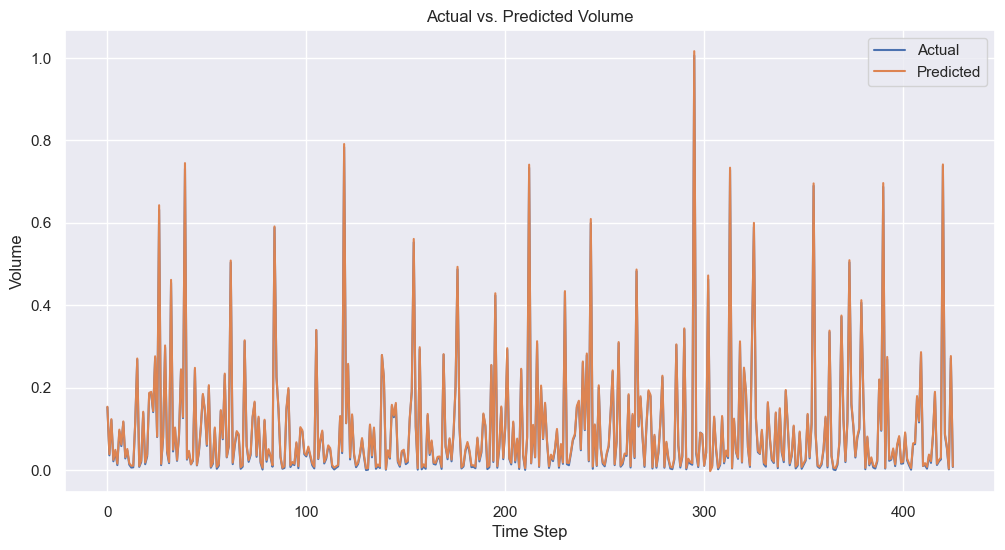

In [10]:
import matplotlib.pyplot as plt

# Plot the actual and predicted values
plt.figure(figsize=(12, 6))
plt.plot(test_sequences_normalized[:, -1], label='Actual')
plt.plot(predictions_normalized, label='Predicted')
plt.xlabel('Time Step')
plt.ylabel('Volume')
plt.title('Actual vs. Predicted Volume')
plt.legend()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler

# Load your dataset into a DataFrame
data = imputed_data

# Ensure the data is sorted by 'year'
data = data.sort_values(by='year')

# Encode 'site_id' if needed

# Define a function to create sequences from the data
def create_sequences(data, sequence_length):
    sequences = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i+sequence_length])
    return np.array(sequences)

# Create sequences of data
sequence_length = 10  # Adjust the sequence length as needed

# Create a MinMaxScaler instance
scaler = MinMaxScaler()

# Normalize the data
data_normalized = scaler.fit_transform(data[['volume']])

# Create the LSTM model
model = keras.Sequential()
model.add(keras.layers.LSTM(50, activation='relu', input_shape=(sequence_length, 1)))
model.add(keras.layers.Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model on the entire dataset
train_data = create_sequences(data_normalized, sequence_length)
model.fit(train_data[:, :-1], train_data[:, -1], epochs=50, batch_size=32)

# Define the number of years to predict into the future
years_to_predict = 5

# Initialize a dictionary to store predictions for each site_id
site_predictions = {}

# Loop through unique site_id values
unique_site_ids = data['site_id'].unique()

for site_id in unique_site_ids:
    # Extract the relevant data for the specified site_id
    site_data = data[data['site_id'] == site_id]

    # Initialize a list to store predictions for the current site_id
    site_predictions[site_id] = []

    # Iterate through years to predict into the future
    for year_to_predict in range(2024, 2024 + years_to_predict):
        # Extract the sequence of data for the specified site and years leading up to the current year
        input_data = site_data[site_data['year'] >= (year_to_predict - sequence_length)]

        # If there are not enough time steps, extend the data by duplicating the last available time step
        while len(input_data) < sequence_length:
            last_available_time_step = input_data[['volume']].iloc[-1]
            input_data = pd.concat([input_data, last_available_time_step], ignore_index=True)

        # Normalize the input data using the same scaler
        input_data_normalized = scaler.transform(input_data[['volume']])

        # Reshape the input data to match the model's input shape
        input_data_normalized = input_data_normalized.reshape(1, sequence_length, 1)

        # Use the model to make predictions for the current year
        custom_prediction_normalized = model.predict(input_data_normalized)

        # Inverse transform the prediction to the original scale
        custom_prediction_original_scale = scaler.inverse_transform(custom_prediction_normalized)

        # Append the prediction for the current year to the list
        site_predictions[site_id].append((year_to_predict, custom_prediction_original_scale[0, 0]))

# Print the predictions for each site_id
for site_id, predictions in site_predictions.items():
    print(f'Site: {site_id}')
    for year, volume in predictions:
        print(f'Year {year}: Predicted volume: {volume}')
    print()

Epoch 1/50


ValueError: in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py", line 1377, in train_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py", line 1360, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py", line 1349, in run_step  **
        outputs = model.train_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py", line 1126, in train_step
        y_pred = self(x, training=True)
    File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_3" is incompatible with the layer: expected shape=(None, 10, 1), found shape=(None, 9, 1)


In [19]:
import pandas as pd

# Sample yearly "volume" data with DateTime index
yearly_data = pd.Series([1000, 1200, 1500, 1400], index=pd.to_datetime(['2019-01-01', '2020-01-01', '2021-01-01', '2022-01-01']))

# Specify the specific days you want to interpolate (1st, 8th, 15th, and 22nd)
interpolation_days = [1, 8, 15, 22]

# Create a DataFrame with daily frequency
daily_data = yearly_data.resample('D').asfreq()

# Filter data to retain only the specified days
filtered_data = daily_data[daily_data.index.day.isin(interpolation_days)]

# Interpolate values for the specified days
interpolated_data = filtered_data.interpolate(method='linear')

# The 'interpolated_data' DataFrame now contains interpolated values for the specified days of every month
print(interpolated_data)

2019-01-01    1000.000000
2019-01-08    1004.166667
2019-01-15    1008.333333
2019-01-22    1012.500000
2019-02-01    1016.666667
                 ...     
2021-12-01    1408.333333
2021-12-08    1406.250000
2021-12-15    1404.166667
2021-12-22    1402.083333
2022-01-01    1400.000000
Length: 145, dtype: float64
